<center>
<h1 style="font-family:verdana">
 💻 🧑 Classificació d'intencions 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta pràctica aprendrem a detectar la intenció de l'usuari a partir d'interaccions reals amb un xatbot. En el context de xatbots, la classificació d'intencions ajuda a entendre quina acció o resposta hauria de prendre el sistema en funció de la consulta de l'usuari.  


<p> ✨ <b>Contingut</b>: en primer lloc, farem servir una base de dades amb oracions d'interaccions en anglés etiquetades com 22 intencions diferents. En segon lloc, realitzarem el preprocessament de les dades, és a dir, transformarem les dades perquè tinguen un format adequat per a ser introduïdes al model. I finalment, dissenyarem i entrenarem el model de classificació per detectar automàticament la intenció de les oracions.</p>  


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>



---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
2. [Preprocessament de dades](#section-two)
  * [Exercici 2](#ex-two)
  * [Exercici 3](#ex-three)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 4](#ex-four)
  * [Exercici 5](#ex-five)
4. [Lliurable](#section-four)
---

In [80]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization #Remove
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [81]:
'''!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz'''

'!pip install gdown\n!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"\n!tar -zxf nlu_ATIS_data.tar.gz'

<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

A la carpeta `data` tenim els diferents fitxers CSV que utilitzarem per a aquesta pràctica.

En primer lloc, llegirem les dades dels fitxers CSV amb `pandas`.

In [82]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


Per a aquesta primera part de la pràctica ens centrarem en la primera columna dels arxius que correspon amb les **oracions** en anglès introduïdes per l'usuari. I en la tercera columna que correspon amb la **intenció** de cada oració, és a dir, cada oració tindrà una etiqueta.

Podeu executar la cel·la següent tantes vegades com vulgueu per veure instàncies d'aquest conjunt de dades.


In [83]:
random_number = random.randint(0, len(train_data)-1)

train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[2])
train_labels = list(s.replace(' ', '') for s in train_labels)

print('Sentence: ', train_sentences[random_number])
print('Intent: ', train_labels[random_number])

Sentence:  okay on the following wednesday i 'd like to go from memphis to cincinnati as early as possible
Intent:  flight


A continuació analitzarem quantes etiquetes diferents hi ha al dataset i quines són.

In [84]:
num_labels = 0
for label in set(train_labels):
  print(f'Label {num_labels}:', label.split('.')[-1])
  num_labels += 1

print(f'\nThere are a total of {num_labels} intent labels')

Label 0: quantity
Label 1: meal
Label 2: aircraft
Label 3: restriction
Label 4: ground_fare
Label 5: flight+airfare
Label 6: flight_time
Label 7: flight
Label 8: distance
Label 9: airport
Label 10: airline+flight_no
Label 11: city
Label 12: airfare+flight_time
Label 13: ground_service
Label 14: aircraft+flight+flight_no
Label 15: ground_service+ground_fare
Label 16: cheapest
Label 17: flight_no
Label 18: airline
Label 19: airfare
Label 20: abbreviation
Label 21: capacity

There are a total of 22 intent labels


<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

En primer lloc, haurem de tokenitzar les oracions. Això consisteix a convertir el text en representacions numèriques, ja que els models esperen unitats discretes.

En aquesta pràctica farem servir una tokenització senzilla, simplement dividirem les oracions en paraules i crearem un vocabulari basat en les paraules úniques de les dades d'entrenament. Cada paraula (token) tindrà assignat un ID únic.

Vegem com queda el vocabulari.

In [85]:
num_words=500 # Vocab size millor per decrementar el nombre de OOV. SI num_words == 10, ID = 1 amb major freq serà OOV. 
tokenizer = Tokenizer(num_words, oov_token="<OOV>") ## ELS WORDS QUE NO ENTREN DINTRE DELS 500, ELS TRACTEM COM A OOV (OUT OF VOCABULARY)
tokenizer.fit_on_texts(train_sentences) # ASSIGNAR ID A CADA PARAULA DEL TRAIN.

vocab = tokenizer.word_index
print(vocab)
len(vocab)

{'<OOV>': 1, 'to': 2, 'from': 3, 'flights': 4, 'the': 5, 'on': 6, 'what': 7, 'me': 8, 'flight': 9, 'boston': 10, 'show': 11, 'san': 12, 'i': 13, 'denver': 14, 'a': 15, 'francisco': 16, 'in': 17, 'and': 18, 'atlanta': 19, 'pittsburgh': 20, 'is': 21, 'dallas': 22, 'baltimore': 23, 'all': 24, 'philadelphia': 25, 'like': 26, 'are': 27, 'list': 28, 'airlines': 29, 'of': 30, 'between': 31, 'that': 32, 'washington': 33, 'leaving': 34, 'please': 35, 'pm': 36, 'morning': 37, 'would': 38, 'fly': 39, 'for': 40, 'fare': 41, 'first': 42, 'wednesday': 43, 'after': 44, 'there': 45, 'oakland': 46, "'d": 47, 'ground': 48, 'you': 49, 'does': 50, 'trip': 51, 'transportation': 52, 'class': 53, 'arriving': 54, 'cheapest': 55, 'need': 56, 'city': 57, 'round': 58, 'with': 59, 'before': 60, 'which': 61, 'available': 62, 'have': 63, 'give': 64, 'at': 65, 'fares': 66, 'american': 67, 'afternoon': 68, 'one': 69, 'want': 70, 'how': 71, 'way': 72, 'new': 73, 'dc': 74, 'nonstop': 75, 'arrive': 76, 'earliest': 77, '

831

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

En aquest primer exercici us demanem que donat el vocabulari anterior convertiu la llista d'oracions de la partició d'entrenament, és a dir, `train_sentenes` en seqüències d'IDs.

Podeu trobar la documentació [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [86]:
#TODO: Convertir les frases a seqüències d'IDs
train_sequences = tokenizer.texts_to_sequences(train_sentences)
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[13, 70, 2, 39, 3, 10, 65, 416, 85, 18, 76, 17, 14, 65, 494, 17, 5, 37]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
```



---
A continuació haurem d'aconseguir que totes les seqüències tinguen una longitud fixa. Per a fer això primer fixarem la longitud segons la longitud màxima trobada a les seqüències del conjunt d'entrenament. I a continuació omplirem (*pad*) les seqüències que tinguen una longitud menor.


In [87]:
max_sequence_length = max(map(len, train_sequences)) # PER HOMOGENEITZAR LA LLARGADA DE LES SEQÜÈNCIES, S'AFEGIRÀ PADDING FINS LONG MAX.
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  13  70   2  39   3  10  65 416
  85  18  76  17  14  65 494  17   5  37]


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Com l'ordre de les paraules sí que importa als models que utilitzarem en aquesta pràctica, és aconsellable que el *padding* estiga al final i no al principi. Busqueu [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) com fer perquè el codi anterior afegisca els zeros al final i no al principi de la seqüència.

In [88]:
#TODO volem padding al final per tenir en compte l'ordre de les paraules. Mateix inici. 
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 13  70   2  39   3  10  65 416  85  18  76  17  14  65 494  17   5  37
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
```


---

A continuació convertirem les classes d'intencions categòriques (*capacity*, *ground_service*, *flight*, etc.) en el que anomenem one-hot vector encoding (APLICABLE OPERACIONS MATEMÀTIQUES). Aquesta tècnica s'utilitza per representar les dades categòriques com a vectors binaris. On cada vector representa una classe específica i l'element corresponent a la classe es posa a 1 i la resta d'elements es mantenen a 0.

Imaginem que tenim tres classes: *capacity*, *ground_service*, *flight*. Podríem codificar aquestes classes amb un vector únic de la forma següent:


```
   capacity -> [1, 0, 0]
   ground_service -> [0, 1, 0]
   flight -> [0, 0, 1]
```

Per aconseguir això primer codificarem les classes d'intenció en etiquetes numèriques.

In [89]:
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

I a continuació convertim les etiquetes a vectors one-hot.

In [90]:
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

# LA MAJOR AVANTATGE DE ONE-HOT ENCODING EN LES ETIQUETES PERQUÈ TÉ UN SÍMIL AMB LES PROBABILITATS DE SORTIDA.

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')

Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

Amb la partició de validació i test haurem de realitzar els mateixos passos. Per tant, en aquest exercici us demanem que obtingueu `val_pad_sequences`, `val_encoded_labels`, `test_pad_sequences` i `test_encoded_labels`.

In [91]:
#TODO
val_pad_sequences = pad_sequences(tokenizer.texts_to_sequences(val_data[0]), maxlen=max_sequence_length, padding='post')

test_pad_sequences = pad_sequences(tokenizer.texts_to_sequences(test_data[0]), maxlen=max_sequence_length, padding='post')



In [92]:
val_labels = list(val_data[2])
val_labels = list(s.replace('"', '') for s in val_labels)
val_labels = list(s.replace(' ', '') for s in val_labels)

test_labels = list(test_data[2])
test_labels = list(s.replace('"', '') for s in test_labels)
test_labels = list(s.replace(' ', '') for s in test_labels)

def remove_values_and_indices(input_list, values_to_remove, other_list):
    indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    cleaned_list = [item for item in input_list if item not in values_to_remove]
    cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    return cleaned_list, np.array(cleaned_other_list)

values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline'] 
# si algunas clases no lo tienen en el train, quitarlos del val y test también para evitar errores.
val_labels, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
test_labels, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)


In [93]:
val_numerical_labels = label_encoder.transform(val_labels) # solo fit en train para que no aprenda de val/test (que tienen clases nuevas y saldria error).
test_numerical_labels = label_encoder.transform(test_labels)

val_encoded_labels = to_categorical(val_numerical_labels, num_classes) 
test_encoded_labels = to_categorical(test_numerical_labels, num_classes)

---

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

En primer lloc, anem a comprovar si hi ha GPUs disponibles. A continuació si hi ha GPUs disponibles el codi assegurarà que *TensorFlow* només assigne memòria GPU quan siga necessari.

In [94]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. The model will be trained on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU is not available. The model will be trained on CPU.


---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

En aquest exercici haureu de dissenyar l'arquitectura del model. El nostre model tindrà quatre capes:

1. La primera capa serà un **embedding**. Aquesta capa permetrà convertir les dades de text d'entrada, en vectors densos amb una mida fixa (*embedding_dim*). Aquesta representació més compacta permetrà per una part capturar la informació semàntica del text d'entrada, permetent així generalitzar millor i comprendre les relacions entre les paraules. I, per una altra banda, reduir la complexitat computacional, accelerant així el temps d'entrenament i inferència. En resum, aquesta capa assignarà a cada índex de cada paraula un vector dens de mida *embedding_dim*.

2. La segona capa serà un **pooling** layer. L'entrada d'aquesta capa serà un tensor 3D (*batch_size*, *sequence_length*, *embedding_dim*). Aquesta capa es centrarà a capturar la informació més important de la seqüència d'entrada, és a dir, prendrà el valor màxim de la seqüència, donant lloc a un tensor 2D (batch_size, embedding_dim).

3. La tercera capa serà una capa **densa**. És a dir, una capa completament connectada (*fully-connected*): cada neurona d'aquesta capa estarà connectada a totes les neurones de la capa anterior. La funció d'activació que utilitzarem serà una ReLU. Aquesta funció introdueix una no-linealitat al model permetent així aprendre relacions complexes en les dades.

4. L'última capa també serà una capa **densa**. En aquest cas la funció d'activació haurà de ser la funció Softmax. Aquesta funció es fa servir per a convertir els valors de la capa anterior (*logits*) en probabilitats normalitzades. El valor de cada element de sortida representarà la probabilitat que l'entrada pertanya a una classe específica.


📢  Les capes que haureu de fer servir les podreu trobar [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers).





In [95]:
# Importar métricas
from tensorflow.keras.metrics import F1Score

# Modelo
embedding_dim = 500
vocab_size = num_words + 1


def modelo_básico(vocab_size, embedding_dim, max_sequence_length, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))  # layer 1
    model.add(GlobalMaxPooling1D(data_format='channels_last'))  # layer 2
    model.add(Dense(128, activation='relu'))  # layer 3
    model.add(Dense(num_classes, activation='softmax'))  # layer 4

    metrics = tf.keras.metrics.F1Score(average='macro')

    # Compile con métricas básicas
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics = [metrics]
    )
    return model

# Train
def train_model(model, batch_size=32, epochs=10):     
    model.fit(
        train_pad_sequences,
        train_encoded_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_pad_sequences, val_encoded_labels)
    )
    results = model.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size, return_dict=True)
    print(f'Test Loss: {results["loss"]:.4f}')
    f1_value = results.get('f1_score', results.get('f1_macro'))  # compatibilidad con métricas renombradas
    if f1_value is not None:
        print(f'Test F1 Score: {f1_value:.4f}')
    else:
        print('Test F1 Score no disponible en los resultados devueltos.')

modelo = modelo_básico(vocab_size, embedding_dim, max_sequence_length, num_classes)
train_model(modelo, batch_size=32, epochs=10)

Epoch 1/10
128/128 [==============================] - 4s 13ms/step - loss: 1.2111 - f1_score: 0.0407 - val_loss: 0.8770 - val_f1_score: 0.0652
Epoch 2/10
128/128 [==============================] - 4s 13ms/step - loss: 1.2111 - f1_score: 0.0407 - val_loss: 0.8770 - val_f1_score: 0.0652
Epoch 2/10
128/128 [==============================] - 1s 11ms/step - loss: 0.6099 - f1_score: 0.1474 - val_loss: 0.4954 - val_f1_score: 0.1872
Epoch 3/10
128/128 [==============================] - 1s 11ms/step - loss: 0.6099 - f1_score: 0.1474 - val_loss: 0.4954 - val_f1_score: 0.1872
Epoch 3/10
128/128 [==============================] - 1s 10ms/step - loss: 0.3463 - f1_score: 0.2252 - val_loss: 0.3568 - val_f1_score: 0.2210
Epoch 4/10
128/128 [==============================] - 1s 10ms/step - loss: 0.3463 - f1_score: 0.2252 - val_loss: 0.3568 - val_f1_score: 0.2210
Epoch 4/10
128/128 [==============================] - 1s 9ms/step - loss: 0.2134 - f1_score: 0.3433 - val_loss: 0.2619 - val_f1_score: 0.3443


Podeu veure a continuació les oracions que el model ha classificat incorrectament.

In [96]:
probs = modelo.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
test_sentences = test_data[2]
for i in range(0, len(predicted_labels)):
  if test_labels[i] != predicted_labels[i]:
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()


28/28 [==============================] - 0s 3ms/step
Sentence:   "flight+airfare"
Original label:  flight+airfare
Predicted label:  flight

Sentence:   "flight"
Original label:  meal
Predicted label:  flight

Sentence:   "flight"
Original label:  meal
Predicted label:  flight

Sentence:   "flight"
Original label:  airport
Predicted label:  ground_service

Sentence:   "flight"
Original label:  city
Predicted label:  flight

Sentence:   "flight"
Original label:  ground_fare
Predicted label:  airfare

Sentence:   "ground_service"
Original label:  ground_fare
Predicted label:  ground_service

Sentence:   "flight"
Original label:  airport
Predicted label:  flight

Sentence:   "flight"
Original label:  airfare
Predicted label:  flight

Sentence:   "flight"
Original label:  airfare
Predicted label:  flight

Sentence:   "flight"
Original label:  meal
Predicted label:  flight

Sentence:   "flight"
Original label:  aircraft
Predicted label:  quantity

Sentence:   "airfare"
Original label:  fligh

---

 <h1><a name="ex-five"><center> ✏ Exercici 5 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Preprocessament.** Modifiqueu el Tokenizer per canviar la mida del vostre vocabulari i afegiu nous passos de preprocessament. Alguns possibles canvis són canviar la mida del vocabulari, treure la capitalització o fer servir *lemmatització* o *stemming*.

 2. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 3. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.


 4. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.


 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.

 DROPOUT

 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

## Preprocess

In [97]:
## Distribució de les llargades del sentències en el train

EXPERIMENTO 1: Baseline (vocab_size=500, sin preprocesamiento)
Ejemplo original: i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
Vocabulary size: 831

EXPERIMENTO 2: Diferentes tamaños de vocabulario


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiahu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jiahu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiahu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jiahu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Vocab size=100: OOV=18.60%, Palabras únicas=831
Vocab size=300: OOV=3.29%, Palabras únicas=831
Vocab size=300: OOV=3.29%, Palabras únicas=831
Vocab size=400: OOV=1.67%, Palabras únicas=831
Vocab size=400: OOV=1.67%, Palabras únicas=831
Vocab size=500: OOV=0.91%, Palabras únicas=831
Vocab size=500: OOV=0.91%, Palabras únicas=831
Vocab size=831: OOV=0.00%, Palabras únicas=831
Vocab size=831: OOV=0.00%, Palabras únicas=831
Vocab size=1000: OOV=0.00%, Palabras únicas=831
Vocab size=1000: OOV=0.00%, Palabras únicas=831
Vocab size=2000: OOV=0.00%, Palabras únicas=831
Vocab size=2000: OOV=0.00%, Palabras únicas=831
Vocab size=5000: OOV=0.00%, Palabras únicas=831

EXPERIMENTO 3: Lowercase
Ejemplo original: i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
Con lowercase: i want to fly from boston at 838 am and arrive in denver at 1110 in the morning

EXPERIMENTO 4: Stemming
Vocab size=5000: OOV=0.00%, Palabras únicas=831

EXPERIMENTO 3: Lowercase
Ejemplo original: 

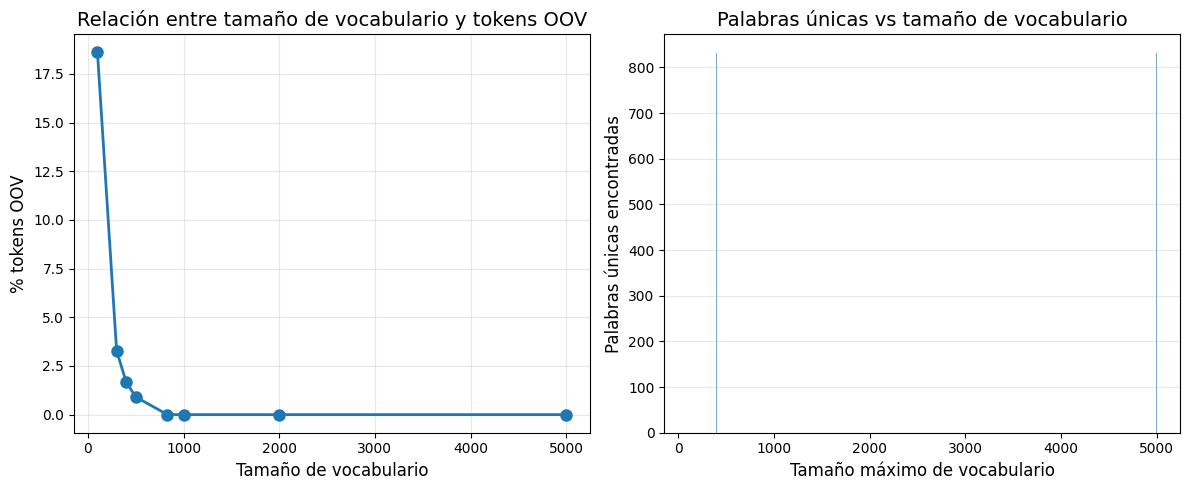


✅ Análisis de preprocesamiento completado!

Próximos pasos:
1. Entrenar modelos con diferentes configuraciones de preprocesamiento
2. Comparar accuracy de cada configuración
3. Analizar qué técnica funciona mejor para este dataset


In [98]:
# Experimentación con diferentes configuraciones de preprocesamiento
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt


# Descargar recursos necesarios de NLTK (ejecutar solo una vez)
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')
    nltk.download('omw-1.4')

# Inicializar herramientas de preprocesamiento
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Función de preprocesamiento
def preprocess_text(text, lowercase=True, remove_stopwords=False, use_stemming=False, use_lemmatization=False):
    """
    Preprocesa el texto aplicando diferentes técnicas.
    
    Args:
        text: Texto a preprocesar
        lowercase: Convertir a minúsculas
        remove_stopwords: Eliminar stopwords
        use_stemming: Aplicar stemming
        use_lemmatization: Aplicar lemmatización
    
    Returns:
        Texto preprocesado
    """
    # Convertir a minúsculas
    if lowercase:
        text = text.lower()
    
    # Tokenizar
    words = text.split()
    
    # Eliminar stopwords
    if remove_stopwords:
        words = [word for word in words if word not in stop_words]
    
    # Aplicar stemming
    if use_stemming:
        words = [stemmer.stem(word) for word in words]
    
    # Aplicar lemmatización
    if use_lemmatization:
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

# Experimento 1: Baseline (sin preprocesamiento adicional, ya está hecho)
print("=" * 60)
print("EXPERIMENTO 1: Baseline (vocab_size=500, sin preprocesamiento)")
print("=" * 60)
print(f"Ejemplo original: {train_sentences[0]}")
print(f"Vocabulary size: {len(vocab)}")
print()

# Experimento 2: Diferentes tamaños de vocabulario
print("=" * 60)
print("EXPERIMENTO 2: Diferentes tamaños de vocabulario")
print("=" * 60)
vocab_sizes = [100, 300, 400, 500, 831, 1000, 2000, 5000]
vocab_size_results = {}

for vocab_size in vocab_sizes:
    tokenizer_temp = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer_temp.fit_on_texts(train_sentences)
    sequences_temp = tokenizer_temp.texts_to_sequences(train_sentences)
    
    # Calcular porcentaje de OOV
    total_tokens = sum(len(seq) for seq in sequences_temp)
    oov_tokens = sum(seq.count(1) for seq in sequences_temp)  # 1 es el token <OOV>
    oov_percentage = (oov_tokens / total_tokens) * 100
    
    vocab_size_results[vocab_size] = {
        'oov_percentage': oov_percentage,
        'vocab_actual': len(tokenizer_temp.word_index)
    }
    
    print(f"Vocab size={vocab_size}: OOV={oov_percentage:.2f}%, Palabras únicas={len(tokenizer_temp.word_index)}")

print()

# Experimento 3: Preprocesamiento con lowercase
print("=" * 60)
print("EXPERIMENTO 3: Lowercase")
print("=" * 60)
train_sentences_lower = [preprocess_text(s, lowercase=True) for s in train_sentences]
print(f"Ejemplo original: {train_sentences[0]}")
print(f"Con lowercase: {train_sentences_lower[0]}")
print()

# Experimento 4: Preprocesamiento con stemming
print("=" * 60)
print("EXPERIMENTO 4: Stemming")
print("=" * 60)
train_sentences_stem = [preprocess_text(s, lowercase=True, use_stemming=True) for s in train_sentences]
print(f"Ejemplo original: {train_sentences[0]}")
print(f"Con stemming: {train_sentences_stem[0]}")

tokenizer_stem = Tokenizer(num_words=500, oov_token="<OOV>")
tokenizer_stem.fit_on_texts(train_sentences_stem)
print(f"Vocabulario original: {len(vocab)}")
print(f"Vocabulario con stemming: {len(tokenizer_stem.word_index)}")
print()

# Experimento 5: Preprocesamiento con lemmatización
print("=" * 60)
print("EXPERIMENTO 5: Lemmatización")
print("=" * 60)
train_sentences_lemma = [preprocess_text(s, lowercase=True, use_lemmatization=True) for s in train_sentences]
print(f"Ejemplo original: {train_sentences[0]}")
print(f"Con lemmatización: {train_sentences_lemma[0]}")

tokenizer_lemma = Tokenizer(num_words=500, oov_token="<OOV>")
tokenizer_lemma.fit_on_texts(train_sentences_lemma)
print(f"Vocabulario original: {len(vocab)}")
print(f"Vocabulario con lemmatización: {len(tokenizer_lemma.word_index)}")
print()

# Experimento 6: Preprocesamiento con eliminación de stopwords
print("=" * 60)
print("EXPERIMENTO 6: Sin stopwords")
print("=" * 60)
train_sentences_no_stop = [preprocess_text(s, lowercase=True, remove_stopwords=True) for s in train_sentences]
print(f"Ejemplo original: {train_sentences[0]}")
print(f"Sin stopwords: {train_sentences_no_stop[0]}")

tokenizer_no_stop = Tokenizer(num_words=500, oov_token="<OOV>")
tokenizer_no_stop.fit_on_texts(train_sentences_no_stop)
print(f"Vocabulario original: {len(vocab)}")
print(f"Vocabulario sin stopwords: {len(tokenizer_no_stop.word_index)}")
print()

# Visualizar impacto de diferentes vocab sizes
print("=" * 60)
print("RESUMEN: Impacto del tamaño de vocabulario")
print("=" * 60)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(vocab_size_results.keys()), 
         [v['oov_percentage'] for v in vocab_size_results.values()], 
         marker='o', linewidth=2, markersize=8)
plt.xlabel('Tamaño de vocabulario', fontsize=12)
plt.ylabel('% tokens OOV', fontsize=12)
plt.title('Relación entre tamaño de vocabulario y tokens OOV', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(list(vocab_size_results.keys()), 
        [v['vocab_actual'] for v in vocab_size_results.values()],
        color='steelblue', alpha=0.7)
plt.xlabel('Tamaño máximo de vocabulario', fontsize=12)
plt.ylabel('Palabras únicas encontradas', fontsize=12)
plt.title('Palabras únicas vs tamaño de vocabulario', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Análisis de preprocesamiento completado!")
print("\nPróximos pasos:")
print("1. Entrenar modelos con diferentes configuraciones de preprocesamiento")
print("2. Comparar accuracy de cada configuración")
print("3. Analizar qué técnica funciona mejor para este dataset")


In [99]:
# ============================================================
# CONFIGURACIÓN DE SEMILLAS PARA REPRODUCIBILIDAD
# ============================================================

import os

# Definir semilla global
SEED = 1

# Configurar semillas para reproducibilidad
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Para operaciones de Python
os.environ['PYTHONHASHSEED'] = str(SEED)

# Para TensorFlow/Keras (asegurar determinismo)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Configuración adicional para GPU (si está disponible)
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.enable_op_determinism()

print("✅ Semillas configuradas para reproducibilidad")
print(f"   Semilla global: {SEED}")
print("   - Python random")
print("   - NumPy")
print("   - TensorFlow")
print("   - Variables de entorno configuradas")


✅ Semillas configuradas para reproducibilidad
   Semilla global: 1
   - Python random
   - NumPy
   - TensorFlow
   - Variables de entorno configuradas


In [100]:
# ============================================================
# ENTRENAMIENTO AUTOMATIZADO CON DIFERENTES CONFIGURACIONES
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import time

# Utilidades auxiliares para reutilizar el pipeline existente
DEFAULT_BATCH_SIZE = 32
DEFAULT_EPOCHS = 15
EMBEDDING_DIM_BASE = 500

train_sentences_base = [str(sentence) for sentence in train_data[0]]
val_sentences_base = [str(sentence) for sentence in val_data[0]]
test_sentences_base = [str(sentence) for sentence in test_data[0]]

val_labels_raw = [str(label).replace('"', '').replace(' ', '') for label in val_data[2]]
test_labels_raw = [str(label).replace('"', '').replace(' ', '') for label in test_data[2]]

values_to_remove_local = values_to_remove if 'values_to_remove' in globals() else [
    'day_name',
    'airfare+flight',
    'flight+airline',
    'flight_no+airline'
]

_, val_sentences_filtered_np = remove_values_and_indices(
    val_labels_raw,
    values_to_remove_local,
    val_sentences_base
)
_, test_sentences_filtered_np = remove_values_and_indices(
    test_labels_raw,
    values_to_remove_local,
    test_sentences_base
)

val_sentences_filtered = [str(sentence) for sentence in val_sentences_filtered_np.tolist()]
test_sentences_filtered = [str(sentence) for sentence in test_sentences_filtered_np.tolist()]



In [101]:

def apply_preprocessing(sentences, config):
    """Aplica la misma función de preprocesamiento usada en el resto del notebook."""
    return [
        preprocess_text(
            sentence,
            lowercase=config['lowercase'],
            use_stemming=config['use_stemming'],
            use_lemmatization=config['use_lemmatization'],
            remove_stopwords=config['remove_stopwords']
        )
        for sentence in sentences
    ]


def swap_global_sequences(train_seq, val_seq, test_seq):
    """Sustituye temporalmente las secuencias globales para reutilizar train_model."""
    original_data = {
        'train_pad_sequences': globals().get('train_pad_sequences'),
        'val_pad_sequences': globals().get('val_pad_sequences'),
        'test_pad_sequences': globals().get('test_pad_sequences')
    }
    globals()['train_pad_sequences'] = train_seq
    globals()['val_pad_sequences'] = val_seq
    globals()['test_pad_sequences'] = test_seq
    return original_data


def restore_global_sequences(original_data):
    for key, value in original_data.items():
        globals()[key] = value


In [102]:
# Configuraciones a probar
configurations = [
    {
        'name': 'Baseline',
        'vocab_size': 500,
        'lowercase': True,
        'use_stemming': False,
        'use_lemmatization': False,
        'remove_stopwords': False,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    },
    {
        'name': 'Vocab pequeño (100)',
        'vocab_size': 100,
        'lowercase': True,
        'use_stemming': False,
        'use_lemmatization': False,
        'remove_stopwords': False,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    },
    {
        'name': 'Vocab 300',
        'vocab_size': 300,
        'lowercase': True,
        'use_stemming': False,
        'use_lemmatization': False,
        'remove_stopwords': False,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    },
    {
        'name': 'Vocab 400',
        'vocab_size': 400,
        'lowercase': True,
        'use_stemming': False,
        'use_lemmatization': False,
        'remove_stopwords': False,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    },
    {
        'name': 'Vocab mediano (1000)',
        'vocab_size': 1000,
        'lowercase': True,
        'use_stemming': False,
        'use_lemmatization': False,
        'remove_stopwords': False,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    },
    {
        'name': 'Vocab real (831)',
        'vocab_size': 831,
        'lowercase': True,
        'use_stemming': False,
        'use_lemmatization': False,
        'remove_stopwords': False,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    },
    {
        'name': 'Vocab grande (5000)',
        'vocab_size': 5000,
        'lowercase': True,
        'use_stemming': False,
        'use_lemmatization': False,
        'remove_stopwords': False,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    },
    {
        'name': 'Con Stemming',
        'vocab_size': 300,
        'lowercase': True,
        'use_stemming': True,
        'use_lemmatization': False,
        'remove_stopwords': False,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    },
    {
        'name': 'Con Lemmatización',
        'vocab_size': 300,
        'lowercase': True,
        'use_stemming': False,
        'use_lemmatization': True,
        'remove_stopwords': False,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    },
    {
        'name': 'Sin Stopwords',
        'vocab_size': 300,
        'lowercase': True,
        'use_stemming': False,
        'use_lemmatization': False,
        'remove_stopwords': True,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    },
    {
        'name': 'Stemming + Sin Stopwords',
        'vocab_size': 300,
        'lowercase': True,
        'use_stemming': True,
        'use_lemmatization': False,
        'remove_stopwords': True,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    },
    {
        'name': 'Lemmatización + Sin Stopwords',
        'vocab_size': 300,
        'lowercase': True,
        'use_stemming': False,
        'use_lemmatization': True,
        'remove_stopwords': True,
        'batch_size': DEFAULT_BATCH_SIZE,
        'epochs': DEFAULT_EPOCHS
    }
]



In [103]:

# Almacenar resultados
results = []

print("=" * 80)
print("INICIO DE ENTRENAMIENTO AUTOMATIZADO")
print("=" * 80)
print(f"Total de configuraciones a probar: {len(configurations)}")
print(f"Semilla utilizada: {SEED}")
print("=" * 80)
print()

for idx, config in enumerate(configurations, 1):
    print(f"\n{'=' * 80}")
    print(f"CONFIGURACIÓN {idx}/{len(configurations)}: {config['name']}")
    print(f"{'=' * 80}")
    print("Parámetros:")
    print(f"  - Vocab size: {config['vocab_size']}")
    print(f"  - Lowercase: {config['lowercase']}")
    print(f"  - Stemming: {config['use_stemming']}")
    print(f"  - Lemmatización: {config['use_lemmatization']}")
    print(f"  - Sin stopwords: {config['remove_stopwords']}")
    print(f"  - Batch size: {config['batch_size']}")
    print(f"  - Epochs: {config['epochs']}")
    print()

    # Resetear semillas antes de cada configuración para reproducibilidad
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

    start_time = time.time()

    train_processed = apply_preprocessing(train_sentences_base, config)
    val_processed = apply_preprocessing(val_sentences_filtered, config)
    test_processed = apply_preprocessing(test_sentences_filtered, config)

    tokenizer_config = Tokenizer(num_words=config['vocab_size'], oov_token="<OOV>")
    tokenizer_config.fit_on_texts(train_processed)

    train_sequences_config = tokenizer_config.texts_to_sequences(train_processed)
    val_sequences_config = tokenizer_config.texts_to_sequences(val_processed)
    test_sequences_config = tokenizer_config.texts_to_sequences(test_processed)

    all_sequences = train_sequences_config + val_sequences_config + test_sequences_config
    maxlen_config = max(1, max(len(seq) for seq in all_sequences)) if all_sequences else 1

    train_pad_sequences_config = pad_sequences(train_sequences_config, maxlen=maxlen_config, padding='post')
    val_pad_sequences_config = pad_sequences(val_sequences_config, maxlen=maxlen_config, padding='post')
    test_pad_sequences_config = pad_sequences(test_sequences_config, maxlen=maxlen_config, padding='post')

    actual_vocab_size = min(config['vocab_size'], len(tokenizer_config.word_index)) + 1
    print(f"   ✓ Vocabulario real: {len(tokenizer_config.word_index)}")
    print(f"   ✓ Longitud máxima de secuencia: {maxlen_config}")

    model_config = modelo_básico(actual_vocab_size, EMBEDDING_DIM_BASE, maxlen_config, num_classes)
    model_config.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.F1Score(average='macro', name='f1_macro')]
    )

    original_sequences = swap_global_sequences(
        train_pad_sequences_config,
        val_pad_sequences_config,
        test_pad_sequences_config
    )

    try:
        train_model(
            model_config,
            batch_size=config['batch_size'],
            epochs=config['epochs']
        )

        train_eval = model_config.evaluate(
            train_pad_sequences_config,
            train_encoded_labels,
            verbose=0,
            return_dict=True
        )
        val_eval = model_config.evaluate(
            val_pad_sequences_config,
            val_encoded_labels,
            verbose=0,
            return_dict=True
        )
        test_eval = model_config.evaluate(
            test_pad_sequences_config,
            test_encoded_labels,
            verbose=0,
            return_dict=True
        )
        
        # Predicciones para calcular F1-Score manual
        val_predictions = model_config.predict(val_pad_sequences_config, verbose=0)
        test_predictions = model_config.predict(test_pad_sequences_config, verbose=0)
    finally:
        restore_global_sequences(original_sequences)

    # Calcular F1-Score manual para validación y test
    val_pred_labels_config = np.argmax(val_predictions, axis=1)
    val_true_labels_config = np.argmax(val_encoded_labels, axis=1)
    val_f1_macro_manual = f1_score(val_true_labels_config, val_pred_labels_config, average='macro')
    
    test_pred_labels_config = np.argmax(test_predictions, axis=1)
    test_true_labels_config = np.argmax(test_encoded_labels, axis=1)
    test_f1_macro_manual = f1_score(test_true_labels_config, test_pred_labels_config, average='macro')

    elapsed_time = time.time() - start_time

    results.append({
        'Configuración': config['name'],
        'Vocab Size': config['vocab_size'],
        'Vocab Real': len(tokenizer_config.word_index),
        'Maxlen': maxlen_config,
        'Stemming': '✓' if config['use_stemming'] else '✗',
        'Lemmatización': '✓' if config['use_lemmatization'] else '✗',
        'Sin Stopwords': '✓' if config['remove_stopwords'] else '✗',
        'Train Accuracy': train_eval.get('accuracy', np.nan),
        'Val Accuracy': val_eval.get('accuracy', np.nan),
        'Test Accuracy': test_eval.get('accuracy', np.nan),
        'Train F1-Macro': train_eval.get('f1_macro', np.nan),
        'Val F1-Macro': val_f1_macro_manual,
        'Test F1-Macro': test_f1_macro_manual,
        'Tiempo (s)': elapsed_time
    })

    print("\n✅ RESULTADOS:")
    print(f"   - Train Accuracy: {train_eval.get('accuracy', np.nan):.4f}")
    print(f"   - Val Accuracy: {val_eval.get('accuracy', np.nan):.4f}")
    print(f"   - Test Accuracy: {test_eval.get('accuracy', np.nan):.4f}")
    print(f"   - Val F1-Macro: {val_f1_macro_manual:.4f}")
    print(f"   - Test F1-Macro: {test_f1_macro_manual:.4f}")
    print(f"   - Tiempo de entrenamiento: {elapsed_time:.2f} segundos")


INICIO DE ENTRENAMIENTO AUTOMATIZADO
Total de configuraciones a probar: 12
Semilla utilizada: 1


CONFIGURACIÓN 1/12: Baseline
Parámetros:
  - Vocab size: 500
  - Lowercase: True
  - Stemming: False
  - Lemmatización: False
  - Sin stopwords: False
  - Batch size: 32
  - Epochs: 15

   ✓ Vocabulario real: 831
   ✓ Longitud máxima de secuencia: 46
   ✓ Vocabulario real: 831
   ✓ Longitud máxima de secuencia: 46
Epoch 1/15
Epoch 1/15
128/128 [==============================] - 3s 13ms/step - loss: 1.2098 - accuracy: 0.7357 - f1_macro: 0.0403 - val_loss: 0.8774 - val_accuracy: 0.7456 - val_f1_macro: 0.0690
Epoch 2/15
128/128 [==============================] - 3s 13ms/step - loss: 1.2098 - accuracy: 0.7357 - f1_macro: 0.0403 - val_loss: 0.8774 - val_accuracy: 0.7456 - val_f1_macro: 0.0690
Epoch 2/15
128/128 [==============================] - 1s 10ms/step - loss: 0.6213 - accuracy: 0.8507 - f1_macro: 0.1504 - val_loss: 0.5195 - val_accuracy: 0.8711 - val_f1_macro: 0.1712
Epoch 3/15
128/128 [


ENTRENAMIENTO COMPLETADO

📋 RESUMEN DE RESULTADOS (ordenado por Val F1-Macro):
                Configuración  Vocab Size  Vocab Real  Maxlen Stemming Lemmatización Sin Stopwords  Train Accuracy  Val Accuracy  Test Accuracy  Train F1-Macro  Val F1-Macro  Test F1-Macro  Tiempo (s)
                 Con Stemming         300         719      46        ✓             ✗             ✗        0.999755      0.964444       0.931306        0.990719      0.803007       0.685646   23.478333
     Stemming + Sin Stopwords         300         630      30        ✓             ✗             ✓        0.997057      0.947778       0.920045        0.977963      0.783390       0.628185   21.784217
            Con Lemmatización         300         772      46        ✗             ✓             ✗        0.999755      0.958889       0.916667        0.990719      0.774153       0.595580   22.630967
                    Vocab 300         300         831      46        ✗             ✗             ✗        0.999264  

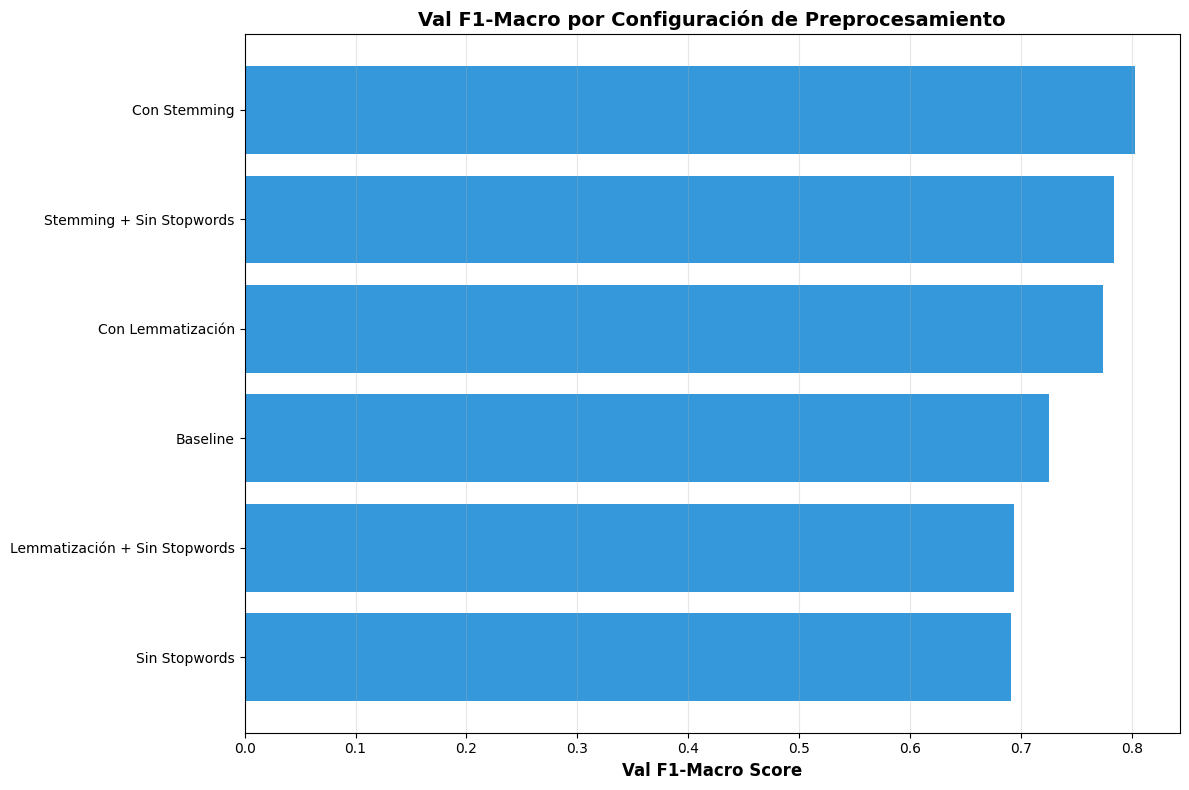

In [108]:
print("\n" + "=" * 80)
print("ENTRENAMIENTO COMPLETADO")
print("=" * 80)

if not results:
    raise RuntimeError("No se generaron resultados. Verifique la configuración del experimento.")

results_df = pd.DataFrame(results)
df_results_sorted = results_df.sort_values('Val F1-Macro', ascending=False).reset_index(drop=True)

print("\n📋 RESUMEN DE RESULTADOS (ordenado por Val F1-Macro):")
print("=" * 80)
print(df_results_sorted.to_string(index=False))

print("\n" + "=" * 80)
print("🏆 TOP 3 MEJORES CONFIGURACIONES (por Val F1-Macro):")
print("=" * 80)
for rank, row in df_results_sorted.head(3).iterrows():
    print(f"\n#{rank + 1}. {row['Configuración']}")
    print(f"   Vocab Size: {row['Vocab Size']} (Real: {row['Vocab Real']})")
    print(f"   Stemming: {row['Stemming']}, Lemmatización: {row['Lemmatización']}, Sin Stopwords: {row['Sin Stopwords']}")
    print(f"   Val Accuracy: {row['Val Accuracy']:.4f}")
    print(f"   Val F1-Macro: {row['Val F1-Macro']:.4f} ⭐")
    print(f"   Test Accuracy: {row['Test Accuracy']:.4f}")
    print(f"   Test F1-Macro: {row['Test F1-Macro']:.4f}")

# ============================================================
# GRÁFICO 1: Val F1-Macro por Configuración de Preprocesamiento
# ============================================================
print("\n📈 Generando gráfico 1: Configuraciones de preprocesamiento...")

# Filtrar solo configuraciones de preprocesamiento (excluir experimentos de vocab size)
preprocessing_mask = results_df['Configuración'].isin([
    'Baseline',
    'Con Stemming',
    'Con Lemmatización',
    'Sin Stopwords',
    'Stemming + Sin Stopwords',
    'Lemmatización + Sin Stopwords'
])
preprocessing_configs = results_df.loc[preprocessing_mask].sort_values('Val F1-Macro', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(preprocessing_configs['Configuración'], preprocessing_configs['Val F1-Macro'], color='#3498db')
plt.xlabel('Val F1-Macro Score', fontsize=12, fontweight='bold')
plt.title('Val F1-Macro por Configuración de Preprocesamiento', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()



📈 Generando gráfico 2: Impacto del tamaño de vocabulario...


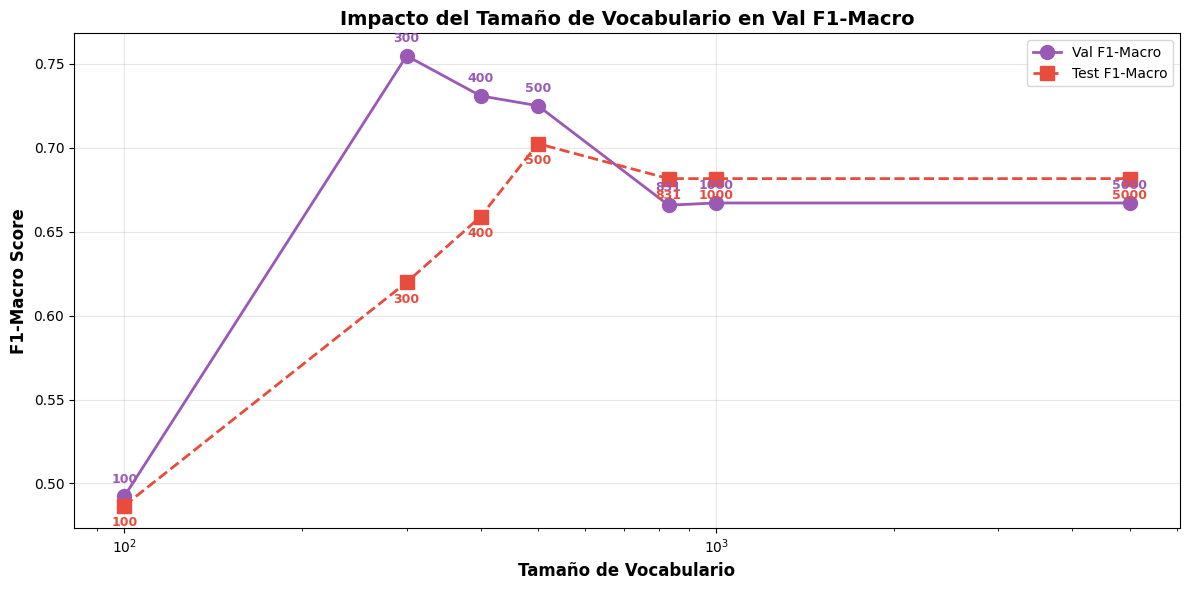


✅ ANÁLISIS COMPLETADO

CONCLUSIONES:
- Mejor configuración (según Val F1-Macro): Con Stemming
- Val F1-Macro más alto: 0.8030
- Test F1-Macro correspondiente: 0.6856
- Ganancia sobre baseline: 7.79%
- Semilla utilizada: 1 (resultados reproducibles)

RECOMENDACIONES:
1. Usar la configuración con mejor Val F1-Macro para el modelo final
2. El modelo se selecciona según validación, no test (evitar overfitting en test)
3. F1-Macro es preferible a accuracy debido al desbalanceo de clases
4. Combinar múltiples técnicas de preprocesamiento puede mejorar resultados
5. Los resultados son reproducibles usando la misma semilla (SEED=1)


In [107]:
# ============================================================
# GRÁFICO 2: Impacto del Tamaño de Vocabulario
# ============================================================
print("\n📈 Generando gráfico 2: Impacto del tamaño de vocabulario...")
vocab_mask = results_df['Configuración'].isin([
    'Baseline',
    'Vocab pequeño (100)',
    'Vocab 300',
    'Vocab 400',
    'Vocab mediano (1000)',
    'Vocab real (831)',
    'Vocab grande (5000)'
])
vocab_configs = results_df.loc[vocab_mask].sort_values('Vocab Size')

plt.figure(figsize=(12, 6))
plt.plot(
    vocab_configs['Vocab Size'],
    vocab_configs['Val F1-Macro'],
    marker='o',
    linewidth=2,
    markersize=10,
    color='#9b59b6',
    label='Val F1-Macro'
)
plt.plot(
    vocab_configs['Vocab Size'],
    vocab_configs['Test F1-Macro'],
    marker='s',
    linewidth=2,
    markersize=10,
    color='#e74c3c',
    linestyle='--',
    label='Test F1-Macro'
)

# Añadir etiquetas con el vocab_size en cada punto
for idx, row in vocab_configs.iterrows():
    # Etiqueta para Val F1-Macro (arriba del punto)
    plt.annotate(
        f'{int(row["Vocab Size"])}',
        xy=(row['Vocab Size'], row['Val F1-Macro']),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        fontsize=9,
        color='#9b59b6',
        fontweight='bold'
    )
    # Etiqueta para Test F1-Macro (abajo del punto)
    plt.annotate(
        f'{int(row["Vocab Size"])}',
        xy=(row['Vocab Size'], row['Test F1-Macro']),
        xytext=(0, -15),
        textcoords='offset points',
        ha='center',
        fontsize=9,
        color='#e74c3c',
        fontweight='bold'
    )

plt.xlabel('Tamaño de Vocabulario', fontsize=12, fontweight='bold')
plt.ylabel('F1-Macro Score', fontsize=12, fontweight='bold')
plt.title('Impacto del Tamaño de Vocabulario en Val F1-Macro', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("✅ ANÁLISIS COMPLETADO")
print("=" * 80)

best_row = df_results_sorted.iloc[0]
baseline_row = results_df.loc[results_df['Configuración'] == 'Baseline']
improvement = float('nan')
if not baseline_row.empty:
    improvement = (best_row['Val F1-Macro'] - baseline_row.iloc[0]['Val F1-Macro']) * 100

print("\nCONCLUSIONES:")
print(f"- Mejor configuración (según Val F1-Macro): {best_row['Configuración']}")
print(f"- Val F1-Macro más alto: {best_row['Val F1-Macro']:.4f}")
print(f"- Test F1-Macro correspondiente: {best_row['Test F1-Macro']:.4f}")
if not np.isnan(improvement):
    print(f"- Ganancia sobre baseline: {improvement:.2f}%")
else:
    print("- Ganancia sobre baseline: No disponible (baseline no computado)")
print(f"- Semilla utilizada: {SEED} (resultados reproducibles)")

print("\nRECOMENDACIONES:")
print("1. Usar la configuración con mejor Val F1-Macro para el modelo final")
print("2. El modelo se selecciona según validación, no test (evitar overfitting en test)")
print("3. F1-Macro es preferible a accuracy debido al desbalanceo de clases")
print("4. Combinar múltiples técnicas de preprocesamiento puede mejorar resultados")
print("5. Los resultados son reproducibles usando la misma semilla (SEED={})".format(SEED))



<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** DE INTENT + NER que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---